In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import random 
import hts
from hts.hierarchy import HierarchyTree

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

import matplotlib.pyplot as plt
import seaborn as sns
from imp import reload


import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
import forecasting.store_item_demand as sid
import forecasting.bplot as bplot

In [3]:
reload(sid);

# Load and Preprocess

In [10]:
df, df_h, hierarchy = sid.preprocess_data('../data/train.csv')


# no null entries
# 10 stores
# 50 items
# 50*10=500 separate time series, one for each store/item combination
# 1826 days = 5 years
# 1826*500 = 913'000 rows of sales data
    
Number of time series at the bottom level: 500
Number of time series at the middle level: 10
Number of time series at the top level   : 1


In [11]:
tree = HierarchyTree.from_nodes(hierarchy, df_h, root='total')

## First look at the data

In [6]:
#HierarchyTree.from_nodes(hierarchy, h_df, root='total')

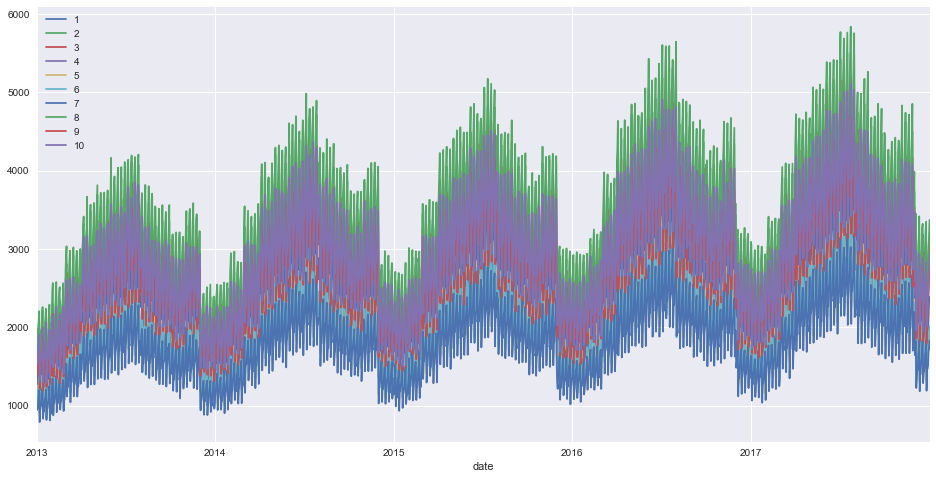

In [7]:
df_h[hierarchy['total']].plot()

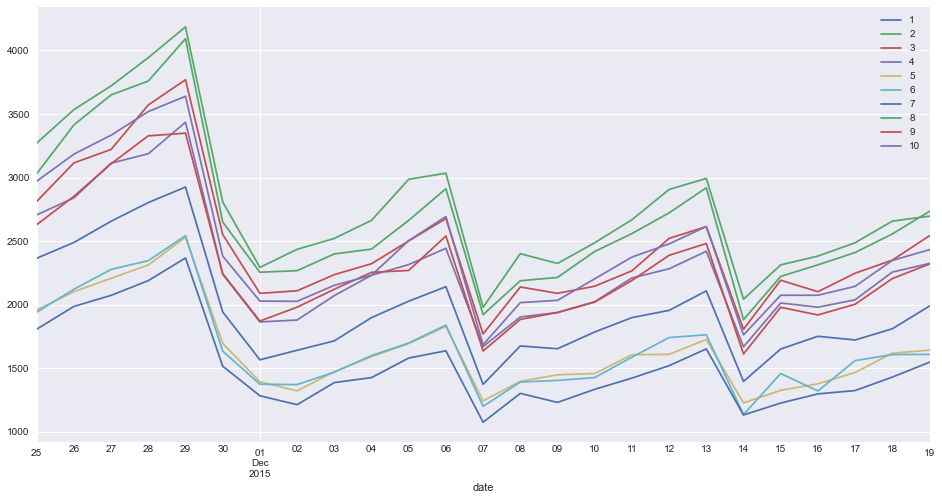

In [8]:
df_h['2015-11-25':'2015-12-19'][hierarchy['total']].plot()

In [9]:
#df_h[hierarchy['total']].plot()

# Testing Prophet

In [ ]:
df_prophet = df_h['1'].to_frame().reset_index()
df_prophet.columns = ['ds', 'y']

In [ ]:
df_prophet.head()

In [ ]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [ ]:
m.fit(df_prophet)

In [ ]:
future = m.make_future_dataframe(periods=90)

In [ ]:
df_forecast = m.predict(future)

In [ ]:
df_forecast.head()

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)])
fig1 = m.plot(df_forecast, ax)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim([datetime.date(2017, 12, 1), datetime.date(2018, 1, 1)])
fig1 = m.plot(df_forecast, ax)

In [ ]:
fig2 = m.plot_components(df_forecast)

In [ ]:
#plot_plotly(m, df_forecast)

In [ ]:
plot_components_plotly(m, df_forecast)

In [ ]:
df_p = performance_metrics(df_cv)
df_p['horizon'] = df_p['horizon'].apply(lambda x: int(str(x).split()[0]))

In [ ]:
df_p.set_index('horizon', inplace=True)

In [ ]:
trace = df_p['smape']*100.

In [ ]:
reload(bplot);

In [ ]:
bplot.plot_timeseries([trace], labels=['smape'], xlabel='horizon', ylabel='smape [%]')

# Cross-validation

In [ ]:
reload(sid);

## Store-level predictions

In [ ]:
stores = hierarchy['total']
store_cvs, store_perfs = sid.cv_loop(df_h, ts_list=stores, progress_bar=False)

In [ ]:
sid.cv_plot(store_perfs, id_label='store', metric='smape')

In [ ]:
store_perfs['1']

## Item-level predictions

In [ ]:
stores = hierarchy['total']
n_sample_stores = 3
n_sample_items = 5

In [ ]:
stores_sample = random.sample(stores, n_sample_stores)
item_perfs_all = {}
for s in stores_sample:
    items = hierarchy[s]
    items_sample = random.sample(items, n_sample_items)
    #print(items_sample)
    item_cvs, item_perfs = sid.cv_loop(df_h, ts_list=items_sample, progress_bar=False)
    sid.cv_plot(item_perfs, id_label='item')
    item_perfs_all.update(item_perfs)

In [ ]:
sum_smape   = 0
count_smape = 0
for k,v in item_perfs_all.items():
    sum_smape   += item_perfs_all[k]['smape'].sum()
    count_smape += item_perfs_all[k]['smape'].count()

In [ ]:
final_overall_smape = sum_smape/count_smape

In [ ]:
final_overall_smape

# Hierarchical time series forecasting

In [ ]:
xmin = '2015-01-01'
xmax = '2015-03-30'
x_range = [xmin, xmax]

In [ ]:
ax = df_h[hierarchy['total']].plot(title="Sales - store level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
ax.set_xlim(x_range);

In [ ]:
ax = df_h[hierarchy['2'][16:17]].plot(title="Sales - item level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
xmin = '2016-01-01'
xmax = '2016-02-01'
x_range = [xmin, xmax]
ax.set_xlim(x_range);

In [ ]:
ax = df_h[hierarchy['2'][40:50]].plot(title="Sales - item level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
ax.set_xlim(x_range);

In [ ]:
#tree = HierarchyTree.from_nodes(hierarchy, df_h, root='total')

In [ ]:
reload(sid);

In [ ]:
pred_hts = sid.calc_store_hier_preds(hierarchy, df_h, store_idx='1')

In [ ]:
sid.plot_comparison(df_train=df_h, df_preds=pred_hts,
                    idx='1', xmin = '2017-09-20', xmax = None)

In [ ]:
sid.plot_comparison(df_train=df_h, df_preds=pred_hts,
                    idx='1_35', xmin = '2016-09-20', xmax = '2017-09-20')

# Model evaluation

In [45]:
reload(sid);

In [ ]:
#df_h, hierarchy

In [39]:
# Preparing the datasets for the simulated historical forecasts
shf_splits = sid.shf_split(df_h, n_years_min_training=3.5, horizon=90)


# full train start : '2013-01-01'
# full train end   : '2017-12-31'
# min train end    : '2016-07-01'
# horizon          :  90 days
    
# number of cutoffs: 7
2017-10-02
2017-08-18
2017-07-04
2017-05-20
2017-04-05
2017-02-19
2017-01-05


### Bottom-up with naive method

In [ ]:
# Getting forecasts for all SHF datasets
forecasts_dict = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='naive',
                                        n_store=None, n_store_items=None, 
                                        verbose=False)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./bu_naive.pickle', obj=forecasts_dict)

In [42]:
df_perf = sid.eval_performance(forecasts_dict)

average SMAPE: 0.25


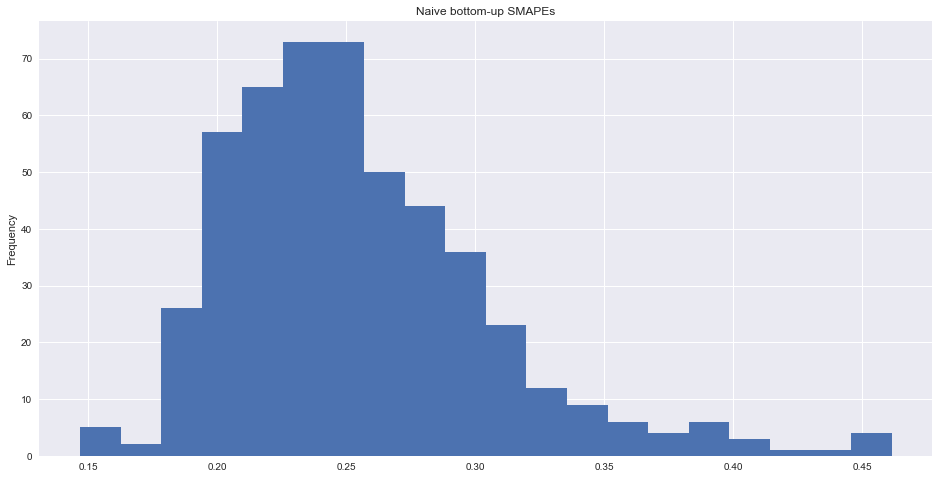

In [43]:
mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.2f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Naive bottom-up SMAPEs')

### Bottom-up with Average method

In [46]:
# Getting forecasts for all SHF datasets
forecasts_dict = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='average',
                                        n_store=None, n_store_items=None, 
                                        verbose=False)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./bu_average.pickle', obj=forecasts_dict)

In [47]:
df_perf = sid.eval_performance(forecasts_dict)

average SMAPE: 0.24


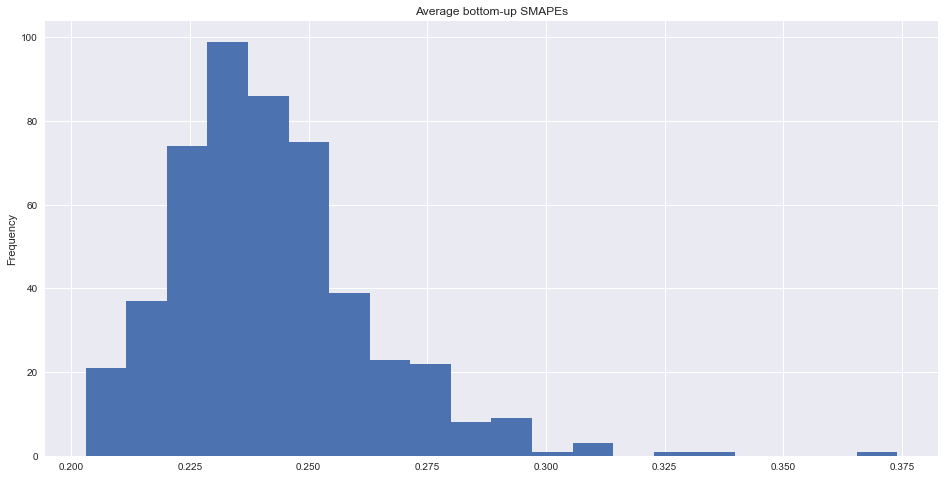

In [48]:
mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.2f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Average bottom-up SMAPEs')

### Bottom-up with Prophet

In [21]:
# Getting forecasts for all SHF datasets
forecasts_dict_prophet = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='prophet',
                                                n_store=None, n_store_items=None, 
                                                verbose=True)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./test.pickle', obj=forecasts_dict_prophet)

In [15]:
# Reading results previously persisted
forecasts_dict_prophet = sid.read_pickle(filename='./prophet_results.pickle')

In [22]:
# Evaluating a bunch of performance metrics
df_perf_prophet = sid.eval_performance(forecasts_dict_prophet)

average SMAPE: 0.12


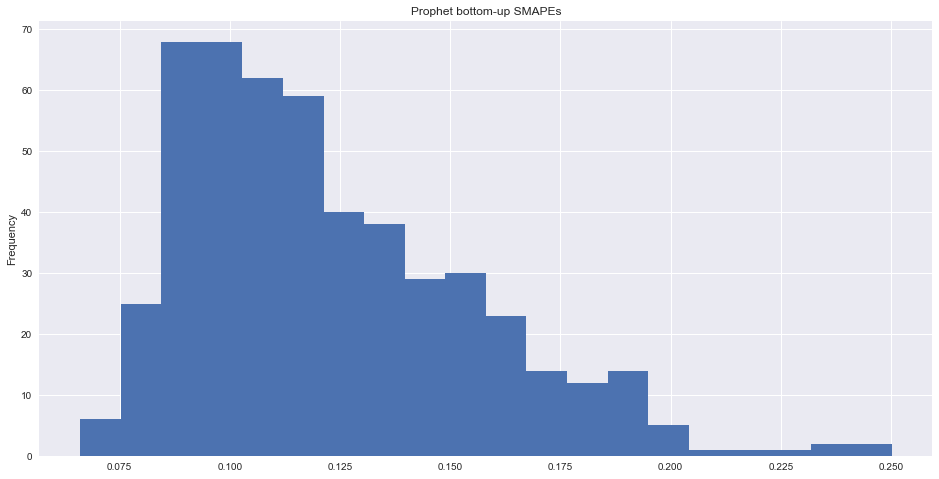

In [37]:
mean_smape = df_perf_prophet.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.2f}')
ax = df_perf_prophet.query(f'h_days==90')['smape'].plot(kind='hist', 
                                                        bins=20, 
                                                        title='Prophet bottom-up SMAPEs')